In [2]:
%matplotlib inline
import numpy as np
import pymc3 as pm
from pymc3.gp.util import plot_gp_dist
import matplotlib.pylab as plt
import matplotlib.cm as cmap
from sklearn.model_selection import train_test_split
import scipy.io
import theano.tensor as tt
import pandas as pd

Using cuDNN version 7003 on context None
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:01:00.0)


### Covariance Kernel

$$K(x_i, x_j) = exp( \frac{-(x_i-x_j)^2}{2l^2})$$

$ls$ is the hyperparameter often referred to as length scale which defines the properties of 'length' as measured between $x_i$ and $x_j$. 

In [3]:
def exponential_cov(x, y, l):
    return np.exp(-(1/(2*(l**2))*np.subtract.outer(x, y)**2))

In [4]:
def covariance(kernel, x1, x2, params): 
    return kernel(x1, x2, params) 

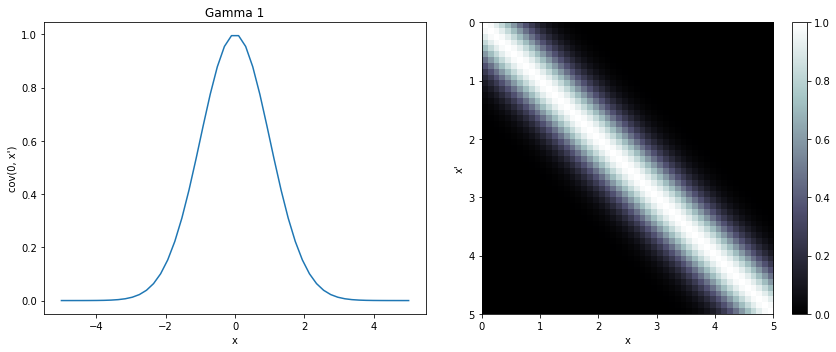

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
xrange = np.linspace(-5, 5)
ax1.plot(xrange, covariance(exponential_cov, 0, xrange, 1))
ax1.set_xlabel('x')
ax1.set_ylabel("cov(0, x')")
ax1.set_title("Gamma 1")

z = np.array([covariance(exponential_cov, xrange, xprime, 1) for xprime in xrange])
ims = ax2.imshow(z, cmap=cmap.bone, 
       interpolation='none', 
       extent=(0, 5, 5, 0))
ax2.set_xlabel('x')
ax2.set_ylabel("x'")
plt.colorbar(ims, ax=ax2)

plt.tight_layout();

In [6]:
#Number of points in X
n = 50
#Number of functions to be samled
j = 10
X = np.linspace(-5, 5, n).reshape(-1,1)
K = covariance(exponential_cov, X, X, 1)
K= K.squeeze()
#Ensure positive definite
K = K + 1e-5*np.eye(n)

In [7]:
#L is the square root of positive definite K_
L = np.linalg.cholesky(K)
#Specify a normal with 0 mean and K covariance
prior_gp = np.dot(L, np.random.normal(0, 1, size=(n,j)))

In [8]:
#This is equivalent to above
#prior_gp = np.random.multivariate_normal(np.zeros(n), K, size=(j))
#prior_gp = prior_gp.T

Text(0,0.5,'f(x)')

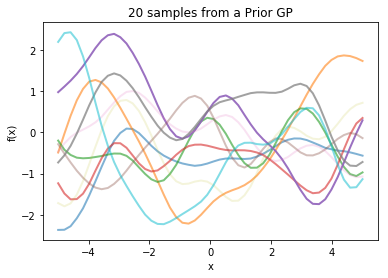

In [9]:
for i in range(j):
    y = prior_gp[:,i]
    plt.plot(X, y,alpha=np.random.rand(), lw=2)
plt.title("20 samples from a Prior GP")
plt.xlabel('x'); plt.ylabel('f(x)')

## Noiseless Regression
In the last excercise, we simply sampled from an infinitely flexible prior GP. Now we shall try to sample from the posterior which is the process of reigning a GP to observed points. We will be using the conditional property of Gaussians to condition the posterior GP on observed data. We also assume that there's no noise, thus, we do not model the uncertainty in data.

In [10]:
x=np.arange(0,10,0.5)
xtrain, xtest = train_test_split(x)
xtrain = np.sort(xtrain)
xtest = np.sort(xtest)

### Conditional equation
$$p(x_1 \mid x_2) = \mathcal{N}(\mu_1 + \Sigma_{12}\Sigma_2^{-1}(x_2-\mu_2), 
\Sigma_1-\Sigma_{12}\Sigma_2^{-1}\Sigma_{12}^T)$$

In [11]:
def conditional(x_new, x, kernel, gamma):
    sigma12 = covariance(kernel, x_new, x, ls)
    sigma2inv = np.linalg.inv(covariance(kernel, x, x, gamma))
    sigma1 = covariance(kernel, x_new, x_new, gamma)
    
    mu = np.dot(np.dot(sigma12, sigma2inv), function(x))
    sigma = sigma1 - np.dot(np.dot(sigma12, sigma2inv), sigma12.T)
    return mu, sigma

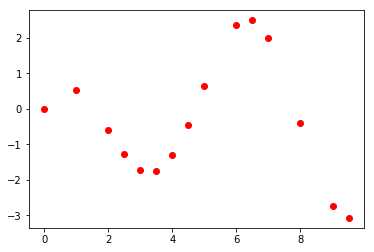

In [12]:
#The data generating function
def function(x):
    return x**.5*np.cos(x)
plt.plot(xtrain, function(xtrain), 'o', c='red');

In [13]:
x_pred = np.linspace(0, 10, 1000)

In [15]:
#Length Scale hyper parameter
ls = 0.5
mu_new, s_new = conditional(x_pred, xtrain, exponential_cov, ls)
#Standard deviation is the error
std = np.sqrt(np.diagonal(s_new))

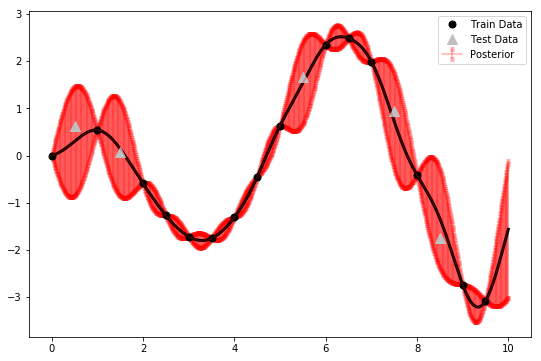

In [17]:
plt.figure(figsize=(9,6))
ax = plt.gca()
#Using 95% HDI
plt.errorbar(x_pred, mu_new, yerr=1.96*std, capsize=2, capthick=5, alpha=0.3, color='red', label='Posterior');
plt.plot(x_pred, mu_new, lw=3, c='black');
plt.plot(xtrain, function(xtrain), 'o',c='black', ms=7, label='Train Data');
plt.plot(xtest, function(xtest), '^', c='silver', ms=10, label='Test Data');
plt.legend(loc=0);

Text(0,0.5,'f(x)')

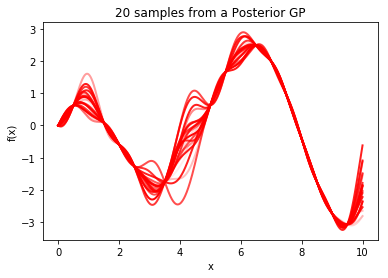

In [16]:
for i in range(20):
    y = np.random.multivariate_normal(mu_new, s_new)
    plt.plot(x_pred, y,alpha=np.random.rand(), lw=2, c='red')
plt.title("20 samples from a Posterior GP")
plt.xlabel('x'); plt.ylabel('f(x)')

What happens when we have noise, like almost always? That is, when we have a function

$$y = f(x) + N(0,\sigma^2)$$

Notice that both terms are Gaussians and noiseless regression is trivially done by adding the $\sigma$ to the function. The new plot should capture uncertainty along all the points. I skip this excercise and jump straight into inference.

## Learning
In most learning problems, values for the hyper-parameters such as the gamma value of the SE kernel would be unkown. 2 key methods to estimate these include 
- Empirical Bayes or MLE(with cross validation)
- Full Bayesian Estimation

The more Bayesian latter approach is used below with PyMC3 library.

In [17]:
mat = scipy.io.loadmat('data/olympics.mat')
olympics = mat['male100'][:, :2]

In [18]:
datx = olympics[:,0]
daty = olympics[:,1]

In [ ]:
X_train, X_test, y, y_test = train_test_split(
            datx, daty, test_size=0.2)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(datx, daty, 'x', label='sampled data')
plt.legend(loc=0);

In [20]:
with pm.Model() as model:
# priors on the covariance function hyperparameters
    length_scale = pm.HalfCauchy('ls', 1)
    scale = pm.HalfCauchy('s', 1)
    
    K = (scale**2) * pm.gp.cov.ExpQuad(1, length_scale) 
    noise = pm.HalfCauchy('σ', 1)

    gp = pm.gp.Marginal(cov_func=K)
    gp.marginal_likelihood('estimate', X=X_train.reshape(-1,1), 
                           y=y, noise=noise)

In [21]:
with model:
    trace = pm.sample(1000, chains=2, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ_log__, s_log__, ls_log__]
100%|██████████| 1500/1500 [00:17<00:00, 84.91it/s]


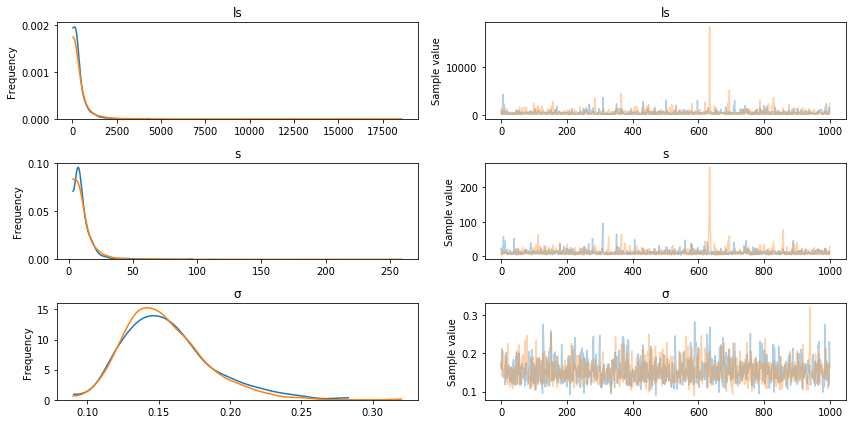

In [22]:
pm.traceplot(trace, varnames=['ls', 's', 'σ']);

In [23]:
X_pred = np.linspace(1800, 2100, 100).reshape(-1, 1)

In [24]:
with model:
    pred = gp.conditional("preds", X_pred, pred_noise=False)
    samples = pm.sample_ppc(trace, vars=[pred], samples=200)

100%|██████████| 200/200 [00:01<00:00, 126.24it/s]


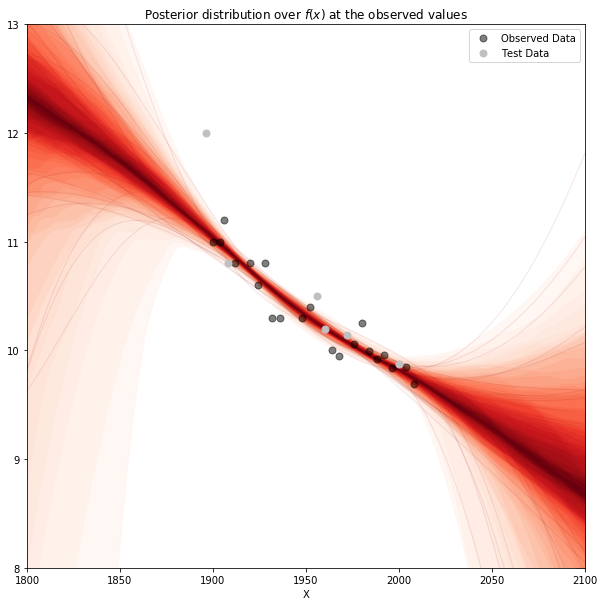

In [26]:
# plot the results
fig = plt.figure(figsize=(10,10)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, samples["preds"], X_pred);

# plot the data and the true latent function
plt.plot(X_train, y, 'ok', ms=7, alpha=0.5, label="Observed Data", c='black');
plt.plot(X_test, y_test, 'ok', c='silver', ms=7, alpha=1, label="Test Data");

# axis labels and title
plt.xlabel("X"); 
plt.ylim([8,13]);
plt.xlim([1800,2100]);

plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

In [27]:
#Making predictions.
with model:
    y_pred = gp.conditional("y_test", X_test.reshape(-1,1))
    y_samples = pm.sample_ppc(trace, vars=[y_pred], samples=1000)
y_pred = np.mean(y_samples['y_test'], 0); y_pred

100%|██████████| 1000/1000 [00:01<00:00, 663.80it/s]


array([ 10.9093731 ,  10.20884071,  10.08248888,  10.2536583 ,
        11.09615254,   9.81899213])

In [28]:
#Mean of Posteriors to use for prediction. Sampling done above also provides similar results.
mean_posterior = {x:np.mean(trace.get_values(x)) for x in trace.varnames}
mu, var = gp.predict(X_test.reshape(-1,1), point=mean_posterior, diag=True, pred_noise=True); mu

array([ 10.91330357,  10.20055886,  10.07169489,  10.24663912,
        11.10926363,   9.82671291])

Let's see how accurate our model is with the olympics so far for which the best times were 9.63(2012) and 9.81(2016)

In [29]:
mu, var = gp.predict(np.array([[2012], [2016]]), point=mean_posterior, diag=True, pred_noise=True); mu

array([ 9.74562891,  9.72174048])

<b>GP:Nil Bolt:2</b> :(

## Sparse GP
Go [here](http://academic.udayton.edu/kissock/http/Weather/citylistWorld.htm) and download a dataset to your liking. We'll be forecasting temperature.  

In [19]:
daily_temps = pd.read_table("data/QTDOHA.txt", sep='\s+', 
                            names=['month','day','year','temp'], na_values=-99)

In [20]:
daily_temps = daily_temps.fillna(method='ffill')

In [21]:
daily_temps.index = np.arange(1,len(daily_temps)+1)

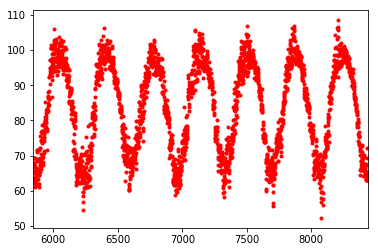

In [22]:
temps_2010 = daily_temps.temp[daily_temps.year>2010]
temps_2010.plot(style='r.')

In [23]:
x, y = temps_2010.reset_index().values.T
X = x.reshape(-1, 1)

X = np.arange(1,len(X)+1)
X = X.reshape(-1,1)

#Converting to celcius
y = (y-32)/1.8

meanx = X.mean()
stdx = X.std()
meany = y.mean()
stdy = y.std()

X = (X-meanx)/stdx
y = (y-meany)/stdy

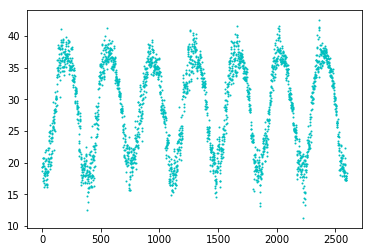

In [24]:
plt.plot((X*stdx)+meanx, (y*stdy)+meany, "co", ms=1, label="Inducing point locations")

In [25]:
with pm.Model() as sparse_model:
    length_scale = pm.HalfCauchy('ls', 1)
    scale = pm.HalfCauchy('s', 1)
    
    K = (scale**2) * pm.gp.cov.ExpQuad(1, length_scale) 
    noise = pm.HalfCauchy('σ', 5)

    gp = pm.gp.MarginalSparse(cov_func=K, approx="FITC")
    Xu = pm.gp.util.kmeans_inducing_points(20, X)
    
    gp.marginal_likelihood('estimate', X=X, Xu=Xu,
                        y=y, sigma=noise)
    
    #trace = pm.sample(1000, chains=2, njobs=1)
    approx_gp = pm.fit(20000, method='fullrank_advi')

Average Loss = 2,192.9: 100%|██████████| 20000/20000 [01:57<00:00, 170.59it/s]
Finished [100%]: Average Loss = 2,187


In [26]:
with sparse_model:
    trace = approx_gp.sample(500)

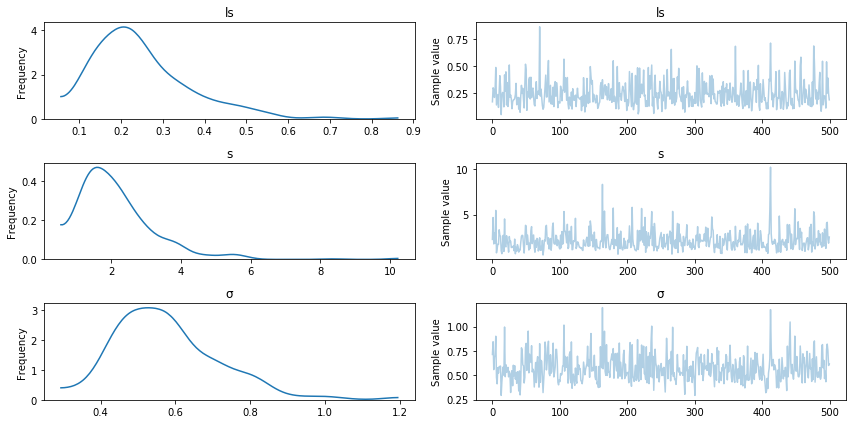

In [27]:
pm.traceplot(trace, varnames=['ls', 's', 'σ']);

In [28]:
X_pred = np.linspace(-5, 5, 1000).reshape(-1, 1)

In [199]:
with sparse_model:
    pred = gp.conditional("preds",X_pred, pred_noise=True)
    samples = pm.sample_ppc(trace, vars=[pred], samples=200)

100%|██████████| 200/200 [00:17<00:00, 11.37it/s]


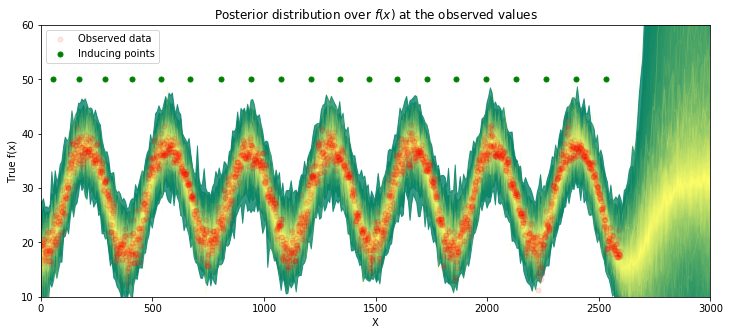

In [203]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, (samples["preds"]*stdy)+meany, (X_pred*stdx)+meanx, palette='summer');

# plot the data and inducing points
plt.plot((X*stdx)+meanx, (y*stdy)+meany, 'ok', c='red', ms=5, alpha=0.1, label="Observed data");
plt.plot((Xu*stdx)+meanx, 50*np.ones(Xu.shape[0]), "co", ms=5, c='green', label="Inducing points")

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.ylim(10, 60)
plt.xlim(0, 3000)


plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

In [29]:
mean_posterior = {x:np.mean(trace.get_values(x)) for x in trace.varnames}

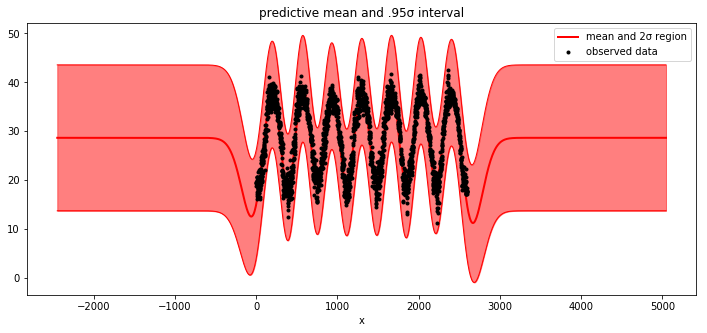

In [37]:
# predict
mu, var = gp.predict(X_pred, point=mean_posterior, diag=True, pred_noise=True)
var = (var*stdy)+meany
sd = np.sqrt(var)
X_predp = (X_pred*stdx)+meanx
mup = (mu*stdy)+meany
# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_predp, mup, 'r', lw=2, label="mean and 2σ region");
plt.plot(X_predp, mup + .96*sd, 'r', lw=1); plt.plot(X_predp, mup - .96*sd, 'r', lw=1);
plt.fill_between(X_predp.flatten(), mup - .96*sd, mup + .96*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot((X*stdx)+meanx, (y*stdy)+meany, 'ok', ms=3, alpha=1.0, label="observed data");

plt.xlabel("x");
plt.title("predictive mean and .95σ interval"); plt.legend();